# Exercise 5

# 1. Optimal Embeddings and Lyapunov Exponents


In [1]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add(["DynamicalSystems", "CairoMakie", "CSV", "NearestNeighbors"])


  Activating new project at `/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_pmNPBp`
   Resolving package versions...
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_pmNPBp/Project.toml`
  [336ed68f] + CSV v0.10.15
  [13f3f980] + CairoMakie v0.13.7
  [61744808] + DynamicalSystems v3.4.1
  [b8a86587] + NearestNeighbors v0.4.21
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_pmNPBp/Manifest.toml`
  [47edcb42] + ADTypes v1.14.0
  [621f4979] + AbstractFFTs v1.5.0
  [1520ce14] + AbstractTrees v0.4.5
  [7d9f7c33] + Accessors v0.1.42
  [79e6a3ab] + Adapt v4.3.0
  [35492f91] + AdaptivePredicates v1.2.0
  [66dad0bd] + AliasTables v1.1.3
  [27a7e980] + Animations v0.4.2
  [ec485272] + ArnoldiMethod v0.4.0
  [4fba245c] + ArrayInterface v7.19.0
  [f3fd9213] + Attractors v1.26.4
  [67c07d97] + Automa v1.1.0
  [13072b0f] + AxisAlgorithms v1.1.0
  [39de3d68] + AxisArrays v0.4.7
  [18cc8868] + BaseDirs v1.3.0
  [62783981] + BitTwiddlingConvenienc

In [2]:
using DynamicalSystems, CairoMakie, NearestNeighbors

The [Rössler system](https://en.wikipedia.org/wiki/R%C3%B6ssler_attractor) is a three-dimensional continuous-time nonlinear dynamical system with chaotic dynamics similar to the Lorenz system. The equations of motion are,

$$\begin{aligned} \frac{dx}{dt} & = -y - z \\ \frac{dy}{dt} & = x + ay \\ \frac{dz}{dt} & = b + z(x-c) \end{aligned}$$

1. Compute a trajectory of the Rössler system with the default parameters in DynamicalSystems.jl and plot the attractor in the $x-y$, $x-z$, and $y-z$ planes.

In [3]:
ds = Systems.roessler()
Δt = 0.01
tr = trajectory(ds, 5000.0; Ttr = 100.0, Δt)[1];

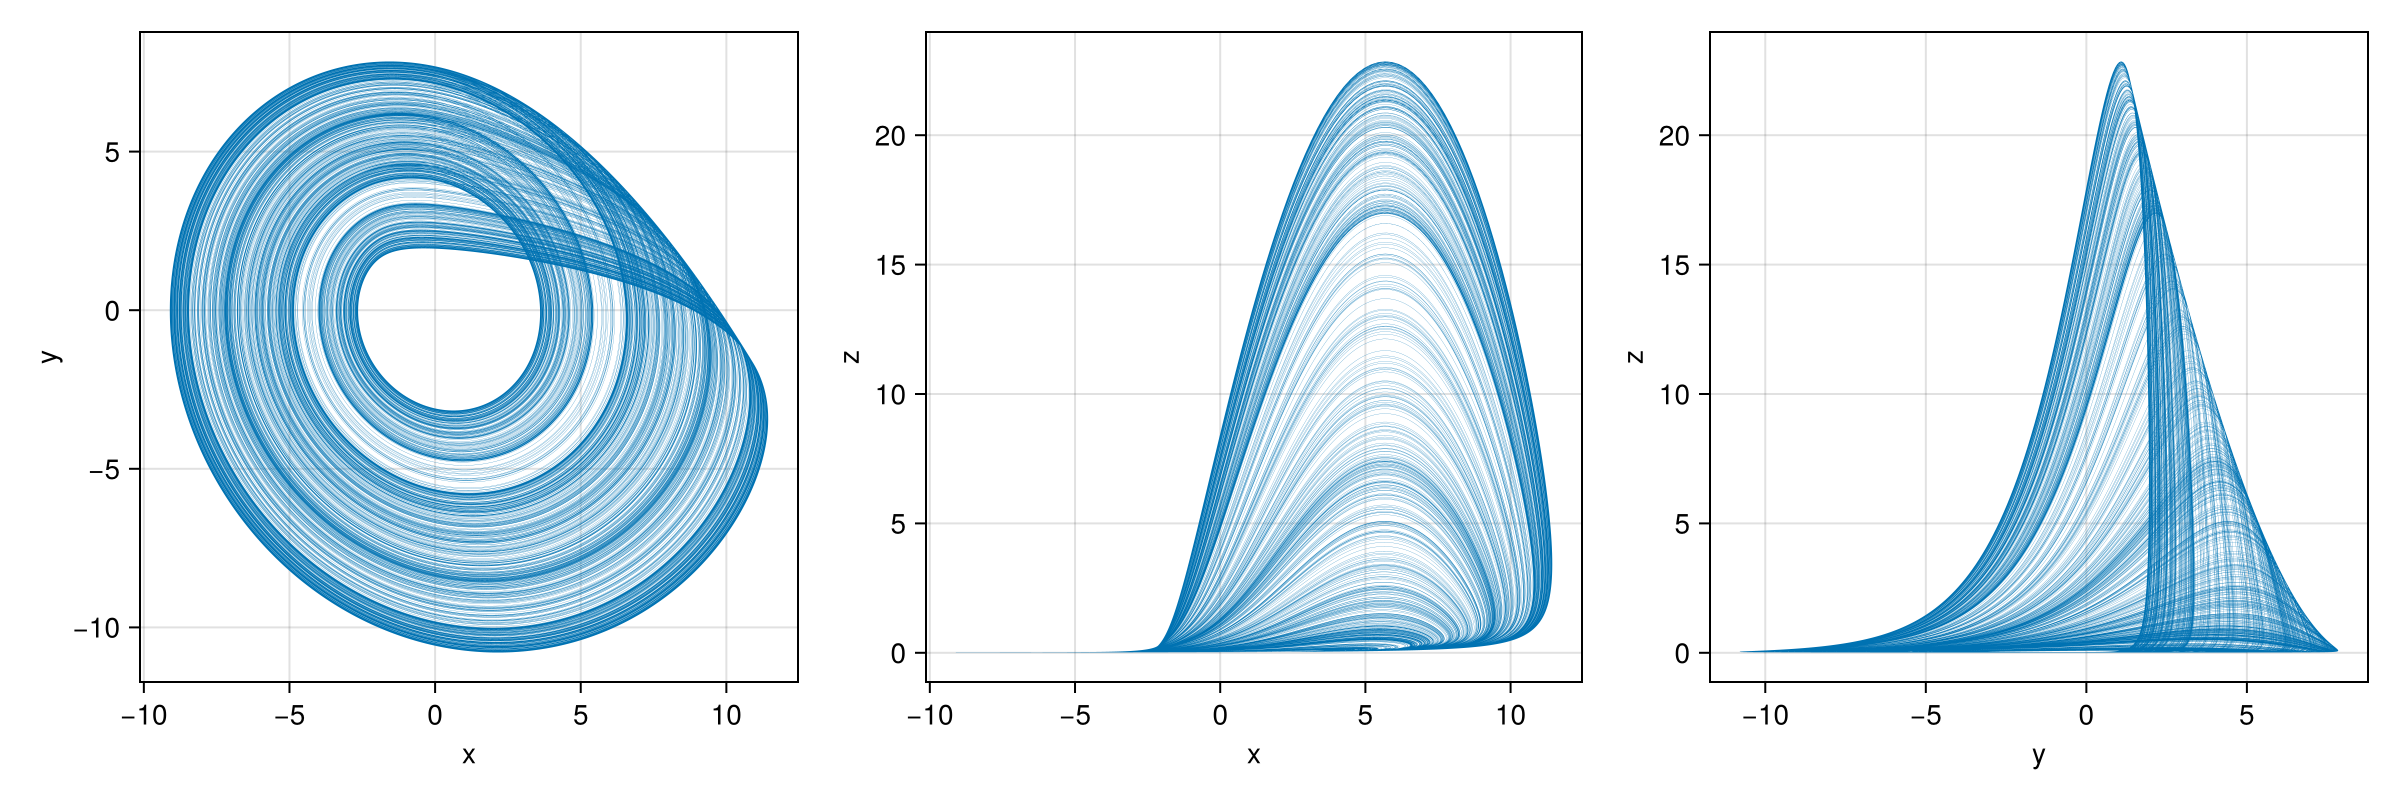

In [4]:
fig = Figure(size = (1200, 400))
lines!(Axis(fig[1, 1], xlabel = "x", ylabel = "y"), tr[:, 1], tr[:, 2], linewidth=0.1)
lines!(Axis(fig[1, 2], xlabel = "x", ylabel = "z"), tr[:, 1], tr[:, 3], linewidth=0.1)
lines!(Axis(fig[1, 3], xlabel = "y", ylabel = "z"), tr[:, 2], tr[:, 3], linewidth=0.1)
fig

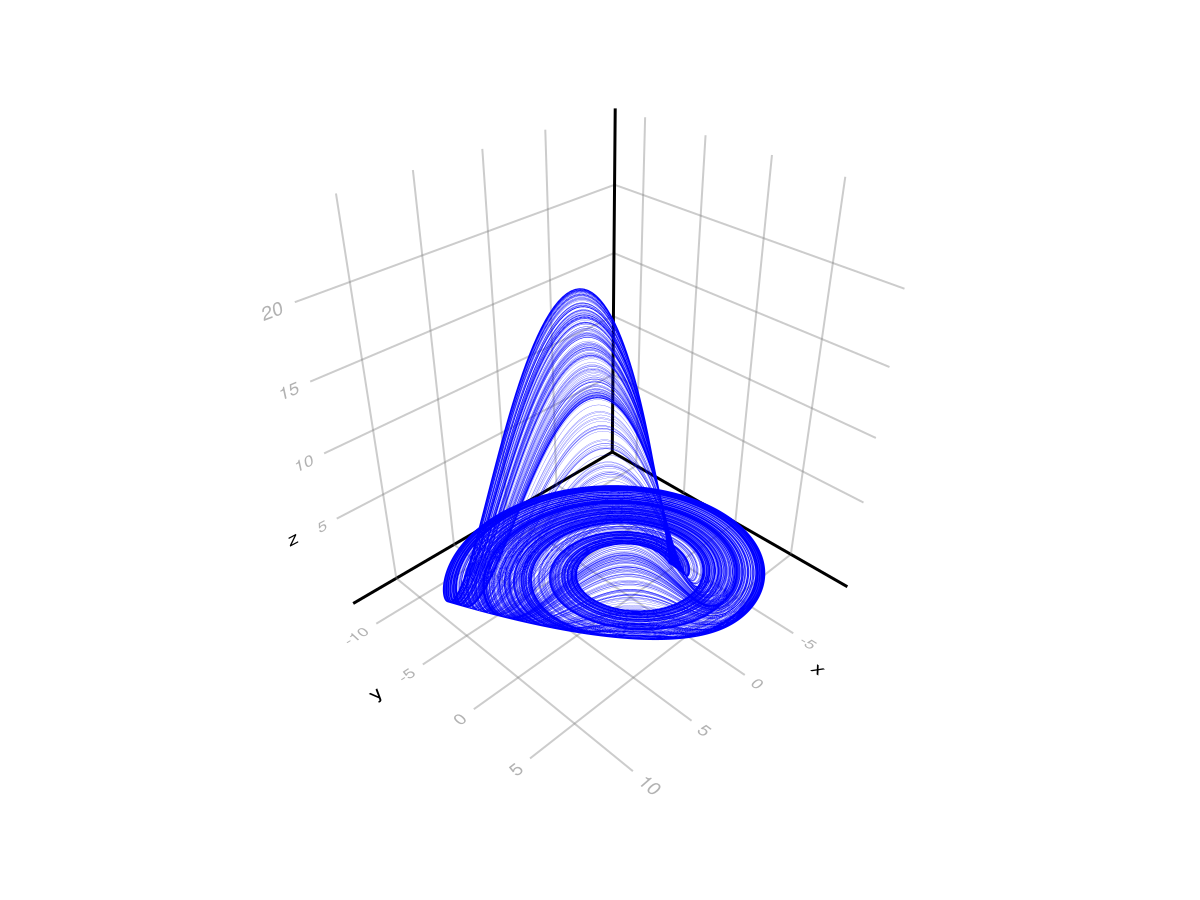

In [5]:
# Also in 3D
lines(tr[:, 1], tr[:, 2], tr[:, 3], linewidth=0.1, color = :blue)

2. Create a one-dimensional time series from this trajectory by keeping only the first dimension.

In [6]:
s = tr[:, 1];

3. Given your one-dimensional time series, use the `optimal_traditional_de` routine from DynamicalSystems.jl to estimate the optimal embedding dimension and delays for the Rössler system.

In [7]:
D, τ, E = optimal_traditional_de(s)

┌ Warning: Did not encounter a minimum, returning last `τ`.
└ @ DelayEmbeddings ~/.julia/packages/DelayEmbeddings/AV1Ee/src/separated_de/estimate_delay.jl:82


Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(4-dimensional StateSpaceSet{Float64} with 499701 points, 100, [4.519059329009624e-6, 0.08079517564180001, 0.8696088681615743, 0.9726273745879278, 0.9766998435459181, 0.9847294863636342, 0.9886556327036666, 0.990187381215094, 0.9925119720386979, 0.9925936193530267])

The algorithm warns us that it didn't encounter a minimum in the mutual information, suggesting that the default range of $\tau$ may be too short (especially considering we've used quite a short timestep of $\Delta t = 0.01$). Let's try increasing the range of $\tau$.

In [8]:
D, τ, E = optimal_traditional_de(s, τs = 1:200)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(4-dimensional StateSpaceSet{Float64} with 499689 points, 104, [4.866358522547429e-6, 0.07389424630707453, 0.8678482822241187, 0.970779053698238, 0.9753643863364112, 0.9856234332961882, 0.9879297116305762, 0.9905575425902764, 0.9919690509600496, 0.9922792070027286])

Now the algorithm works as expected, finding a minimum of the mutual information at $\tau = 104$.

4. Use the optimal embedding to estimate the Lyapunov exponent of the Rössler system using the methods `lyapunov_from_data` and `linear_region`, as shown in the lecture. Remember to plot $E(k)$ versus $k \times \Delta t$. How does your estimate compare to the true Lyapunov exponent? Discuss your answer.

In [9]:
"""Helper function to compute the Lyapunov exponent and plot k x Δt versus E(k)."""
function estimate_lyapunov_from_data(data, k_values, Δt; dxi = 1)    
    E = lyapunov_from_data(data, k_values)  # Returns [E(k) for k ∈ k_values]
    t = k_values .* Δt
    (ind1, ind2), λ = linear_region(t, E; dxi)
    
    println("Identified linear region between t = ", t[ind1], " and t = ", t[ind2])
    println("Estimated Lyapunov exponent λ = ", round(λ, digits = 2))
    
    # Plot the results
    fig = Figure()
    ax = Axis(
        fig[1, 1], 
        xlabel = L"k \times Δt", 
        ylabel="E(k)",
        xminorticks = IntervalsBetween(5),
        xminorgridvisible = true,
        xminorticksvisible = true,
        yminorticks = IntervalsBetween(10),
        yminorgridvisible = true,
        yminorticksvisible = true,
    )
    lines!(
        ax, 
        k_values .* Δt, 
        E,
        label = "λ=$(round(λ, digits = 2))",
    )
    axislegend(ax, position = :rb)
    fig
end

estimate_lyapunov_from_data

Identified linear region between t = 3.2 and t = 3.3
Estimated Lyapunov exponent λ = 0.25


┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/RrzJy/src/linear_fits/linear_regions.jl:142


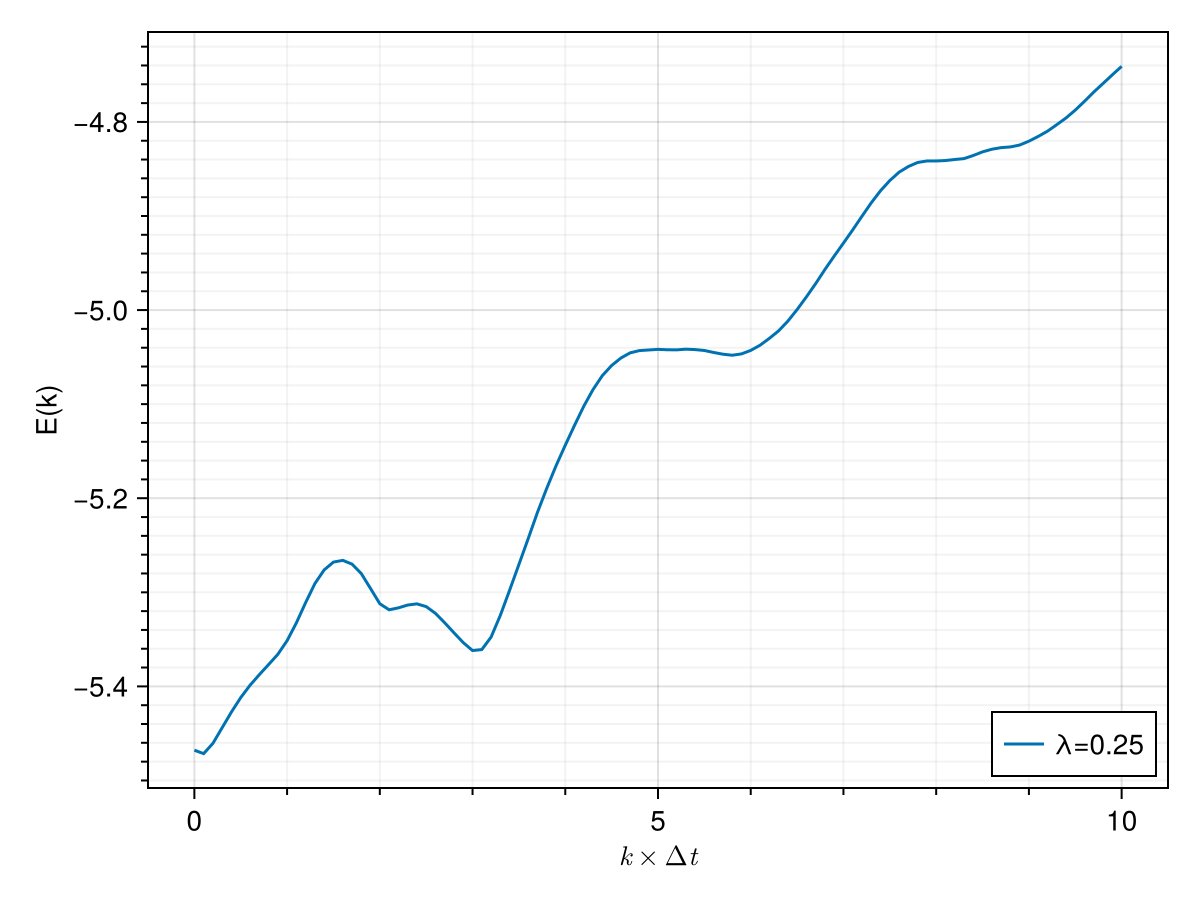

In [10]:
# First try with the same k_values we used in the lecture for the Lorenz system 
estimate_lyapunov_from_data(D, 0:10:1000, Δt)

Observations:
1. The curve is clearly not linear.
2. The automatically identified "linear region" is extremely small and occurs on a steep part of the curve, potentially resulting in an overestimate of the Lyapunov exponent.
3. It is not clear that the curve saturates, suggesting that the range of $k$ may be too short. (One possible explanation for this is that the Lyapunov exponent might be smaller than that of the Lorenz system.)

Let's try significantly increasing the range of $k$.

Identified linear region between t = 3.2 and t = 3.3
Estimated Lyapunov exponent λ = 0.26


┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/RrzJy/src/linear_fits/linear_regions.jl:142


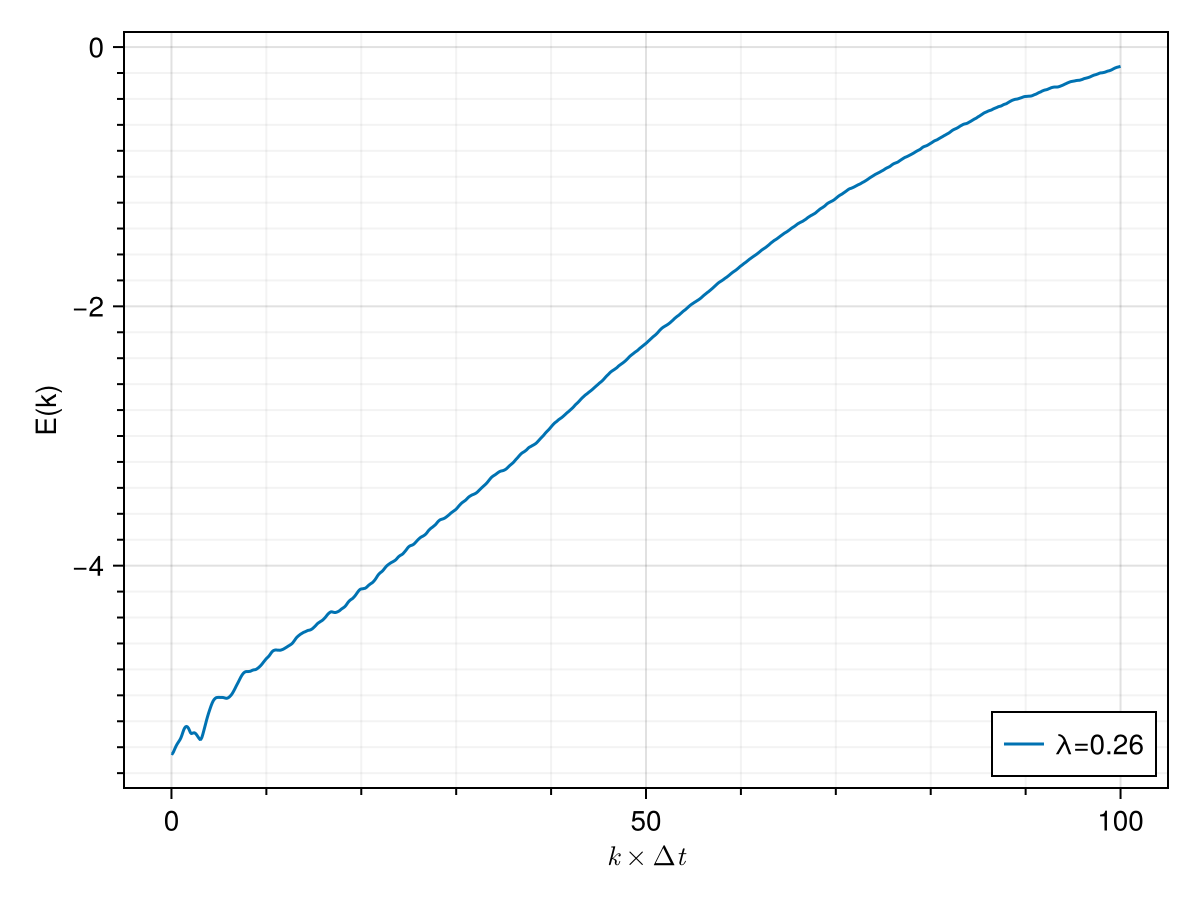

In [11]:
estimate_lyapunov_from_data(D, 0:10:10000, Δt)

Observations:
1. We now see the curve beginning to saturate, albeit after much more time has elapsed than for the Lorenz system.
2. The automatically identified "linear region" is once again extremely small, suggesting the `linear_region` algorithm struggled here.
3. Inspecting the curve, it does appear approximately linear until about $t = 60s$ or so.

Since our timesteps are very small, let's try increasing the size of the interval which is sampled by the `linear_region` algorithm. That's what the keyword argument `dxi` is for (do `?linear_regions` for an explanation of how the algorithm works).

Identified linear region between t = 0.1 and t = 0.2
Estimated Lyapunov exponent λ = 0.07


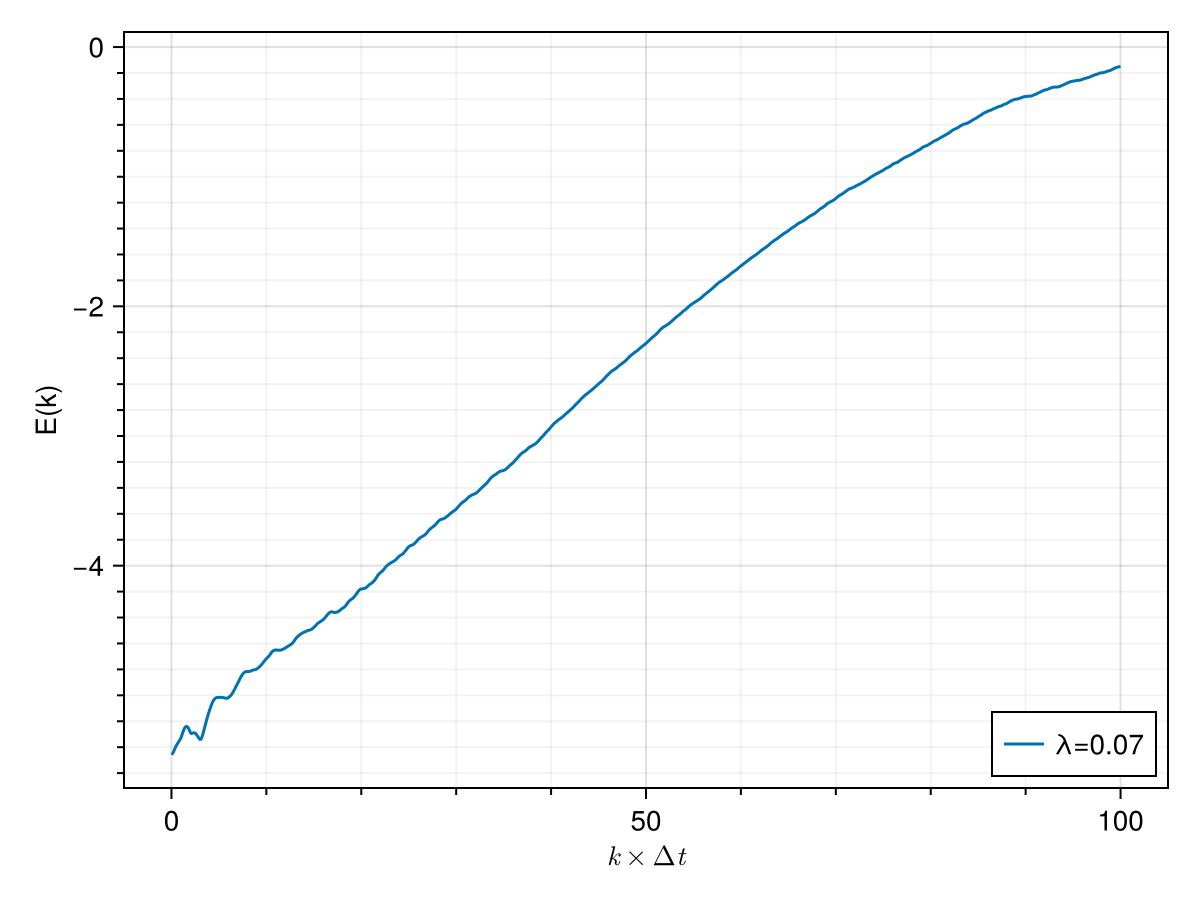

In [17]:
estimate_lyapunov_from_data(D, 0:10:10000, Δt, dxi = 60)

Now the automatically identified "linear region" is reasonably large and seems reasonable, giving an estimate of 0.07 for the largest Lyapunov exponent. How does this compare to the true value?

In [13]:
lyapunov(ds, 10000.0, Ttr = 100.0)

0.06920776649543502

Not bad!

# 2. Forecast of Hourly Temperature Data

Prediction code, copied from the lecture note: 

In [18]:
struct LocalTDEPrediction{T,S,U}
    A::T     # regression coefficients 
    B::T     # regression coefficients 
    N::S     # amount of neighbours 
    tree::U  # neighbourhood tree
end 

"""
    LocalTDEPrediction(data, N::Integer)

Sets up a local linear prediction model, based on a time delay embedding `data`. 
`data` is expected to be `N_t x N_dim`
The prediction is based on the dynamics a local model of `N` neighbours in phase
space
"""
function LocalTDEPrediction(data, N::Integer)
    neighbour_tree = KDTree(transpose(data[1:end-1,:]))  # KDTree is expected it in N_dim x N_points format
    N_d = size(data, 2)
        
    A = zeros(size(data,1)-1, N_d)
    B = zeros(size(data,1)-1, N_d) 
    
    # Loop over the points in the dataset
    for i_point = 1:(size(data,1)-1)
        NN_inds, dists = knn(neighbour_tree, data[i_point,:], N)  # returns the N nearest neighbours

        # Loop over each dimension
        for i = 1:N_d 
            coeffs = hcat(ones(N), data[NN_inds,i]) \ data[NN_inds.+1,i]  # linear regression, seperately for each dimension 
            # we could improve it with a proper MLR
    
            A[i_point, i] = coeffs[1]
            B[i_point, i] = coeffs[2]
        end
    end
    return LocalTDEPrediction(A, B, N, neighbour_tree)
end

"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T})

Predict the system one step ahead from state `ic`. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}) where T
    inds, dists = knn(pred.tree, ic, 1)  # first the closest point 
    ind = inds[1]
    return pred.A[ind,:] .+ pred.B[ind,:] .* ic
end

"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer)

Recursively uses a one step ahead prediction to predict the system for `N` steps. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer) where T
    result = zeros(T, length(ic), N+1)
    result[:,1] = ic
    
    for i=2:N+1 
        result[:,i] = predict(pred, result[:,i-1])
    end 
    
    return result
end 

predict

Now, let's load the data.

In [19]:
using CSV
f = CSV.File("hourly-T-berlin.txt");
T = CSV.getcolumn(f[1],1);

[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]


And plot it 

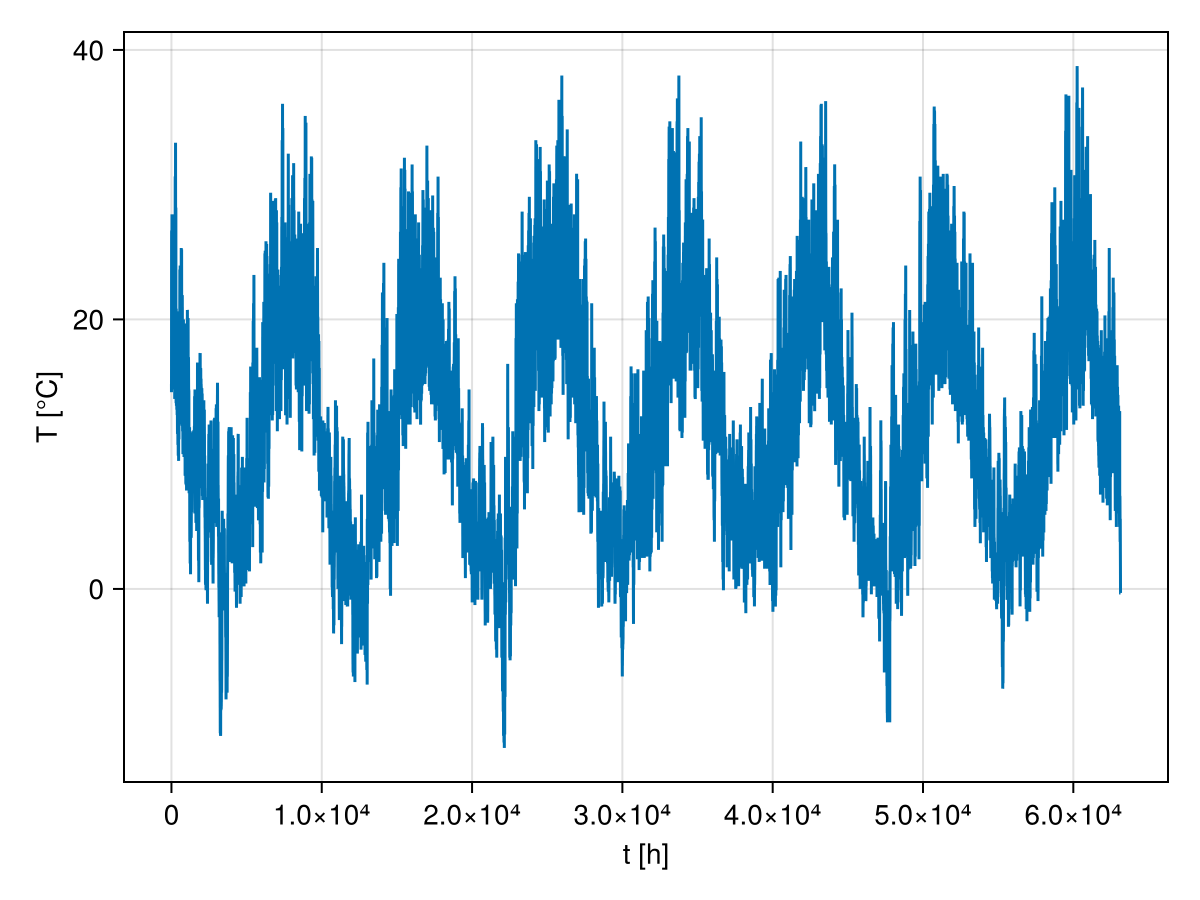

In [20]:
fig = Figure()
ax = Axis(fig[1, 1], 
    xlabel = "t [h]", 
    ylabel="T [°C]",
    )

lines!(ax, T)
fig

We see the annual cycle, and if we zoom in a little, the daily cycle: 

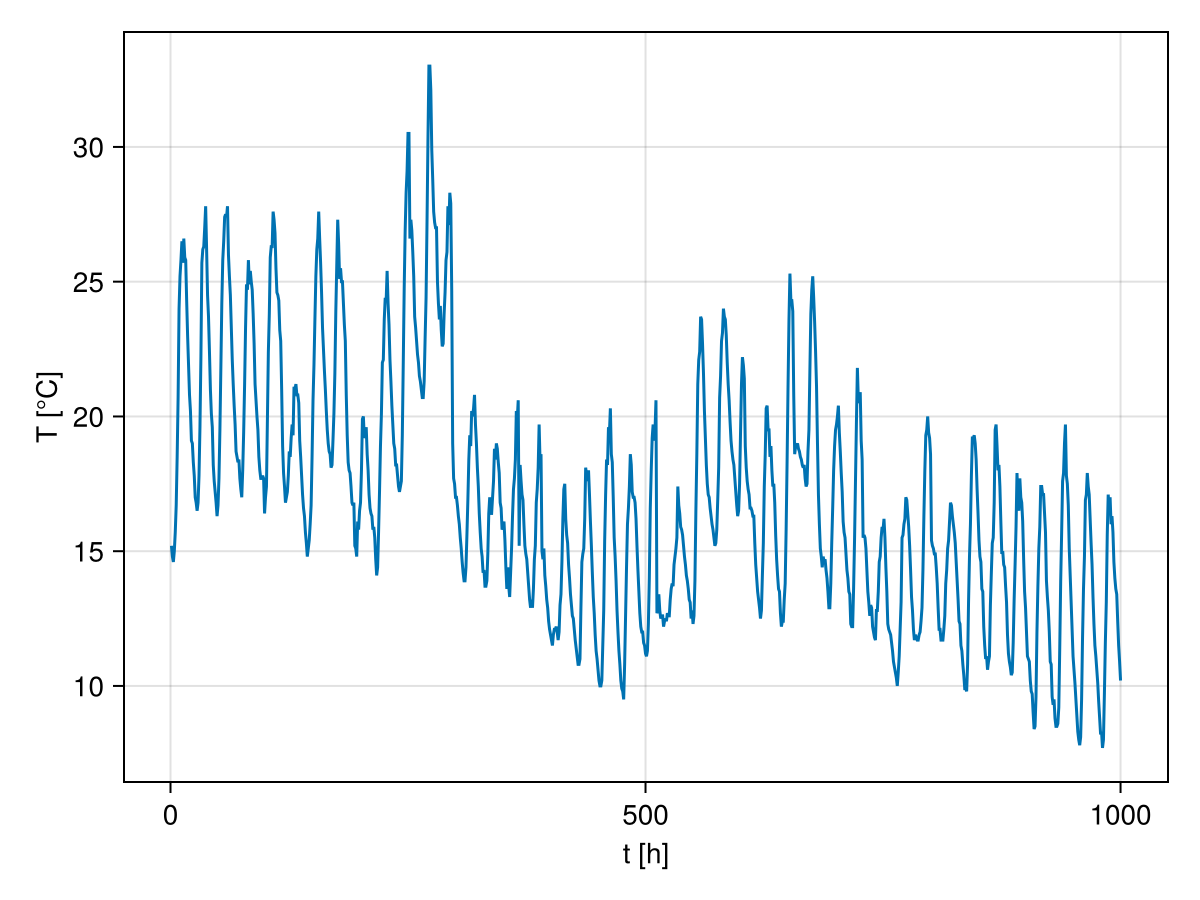

In [21]:
fig = Figure()
ax = Axis(fig[1, 1], 
    xlabel = "t [h]", 
    ylabel="T [°C]",
    )

lines!(ax, T[1:1000])
fig

Let's use the first 50.000 data points to train our prediction model

In [22]:
T_train = T[1:50000];
D, τ, E = DelayEmbeddings.optimal_traditional_de(T_train)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(7-dimensional StateSpaceSet{Float64} with 49922 points, 13, [NaN, NaN, NaN, 0.0, 0.6936903463303791, 0.7916504974542993, 0.8620469718823912, 0.9046411279622302, 0.943255946033355, 0.9514440216589847])

We get a seven-dimensional embedding. Then, we predict for 500 steps

In [40]:
D = Matrix(D)
pred = LocalTDEPrediction(D, 37)
prediction_result = predict(pred, D[end,:], 500);


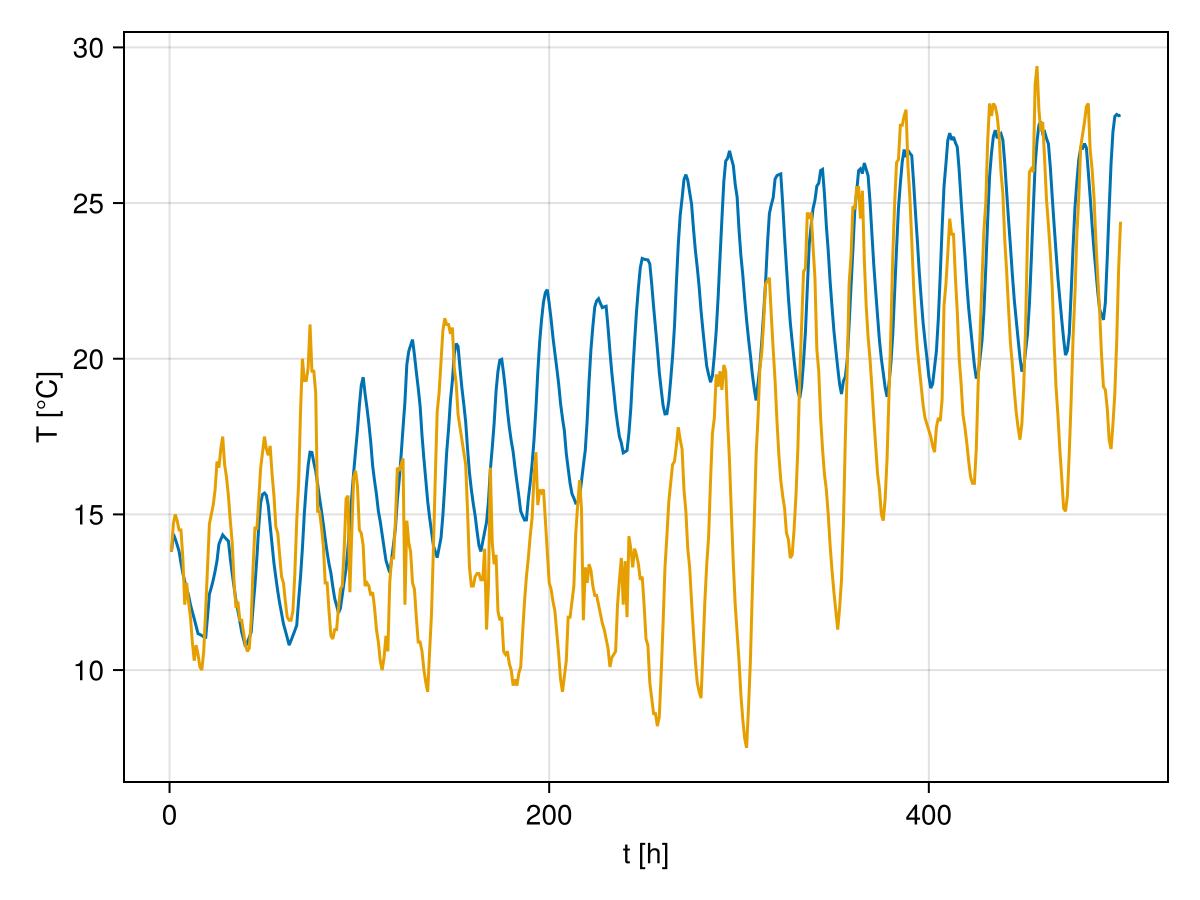

In [41]:
fig = Figure()
ax = Axis(fig[1, 1], 
    xlabel = "t [h]", 
    ylabel="T [°C]",
    )

lines!(ax, prediction_result[end,:],  label="prediction")
lines!(T[50000:50500], label="data")

fig

The prediction is far from perfect, but we can't expect to do a perfect weather forecast with such a simple model. 

It does catch the daily cycle of the temperature data and delivers something that sort of resembles a temperature time series. We could try to improve with a more complex prediction, but even with that it is unlikely to achieve more than a few days worth of meaningful forecasts. Weather is very chaotic! As mentioned when introducing Chaos, even the theoretic limit of Weather forecast is just about two weeks.  

